In [22]:
# Download dataset. This is not needed if you have the dataset already

# import kagglehub

# path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

# print("Path to dataset files:", path)

# Data Cleaning and Reformatting

In [23]:
# Function to check the sampling rate of a wav file and valid file path

import wave
import contextlib

def check_sampling_rate(file_path):
    try:
        with contextlib.closing(wave.open(file_path, 'r')) as wav_file:
            sample_rate = wav_file.getframerate()
            print(f"Sampling rate: {sample_rate} Hz")
    except Exception as e:
        print(f"Error: {e}")

file_path = 'data/ravdess-emotional-speech-audio/versions/1/Actor_01/03-01-01-01-01-01-01.wav'
check_sampling_rate(file_path)

Sampling rate: 48000 Hz


In [24]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

import librosa as librosa
import matplotlib.pyplot as plt

import numpy as  np

In [25]:
"""
File naming convention

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).
"""


import os
import pandas as pd

emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

file_dir = "data/ravdess-emotional-speech-audio/versions/1/"

data = []

for actor in os.listdir(file_dir):
    actor_path = os.path.join(file_dir, actor)
    
    if os.path.isdir(actor_path) and actor.startswith("Actor_"):
        actor_number = actor.split("_")[-1]

        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion_code = file[6:8]
                emotion = emotion_mapping.get(emotion_code, "unknown")
                #formatted_filename = f"Actor_{actor_number}_{file}"
                data.append({"emotion": emotion, "file_path": file, "Actor": actor})

df = pd.DataFrame(data)

print(df)

        emotion                 file_path     Actor
0       disgust  03-01-07-01-02-01-24.wav  Actor_24
1     surprised  03-01-08-02-01-01-24.wav  Actor_24
2           sad  03-01-04-01-02-01-24.wav  Actor_24
3         angry  03-01-05-01-01-01-24.wav  Actor_24
4           sad  03-01-04-02-01-01-24.wav  Actor_24
...         ...                       ...       ...
1435    neutral  03-01-01-01-01-01-07.wav  Actor_07
1436      happy  03-01-03-02-01-02-07.wav  Actor_07
1437    neutral  03-01-01-01-01-02-07.wav  Actor_07
1438    disgust  03-01-07-02-01-02-07.wav  Actor_07
1439       calm  03-01-02-02-01-01-07.wav  Actor_07

[1440 rows x 3 columns]


In [26]:
#remove calm emotion
df = df[df.emotion != 'calm']

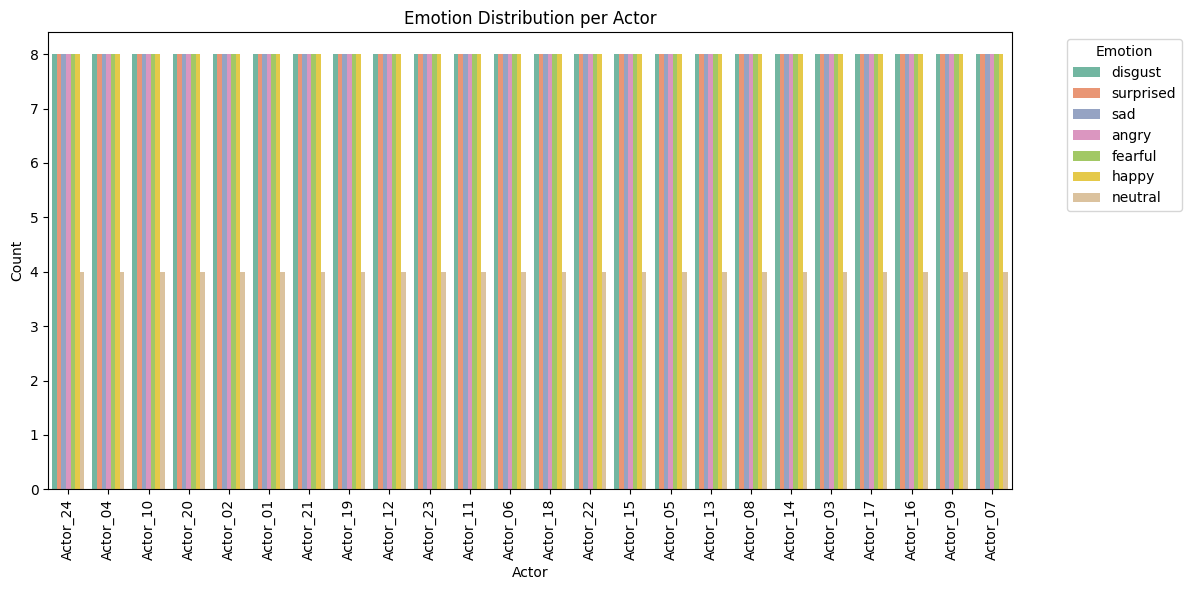

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Actor', hue='emotion', palette='Set2')
plt.title('Emotion Distribution per Actor')
plt.xlabel('Actor')
plt.ylabel('Count')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Extracting waveforms and spectograms

In [28]:
import random 

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=random.uniform(-2, 2))

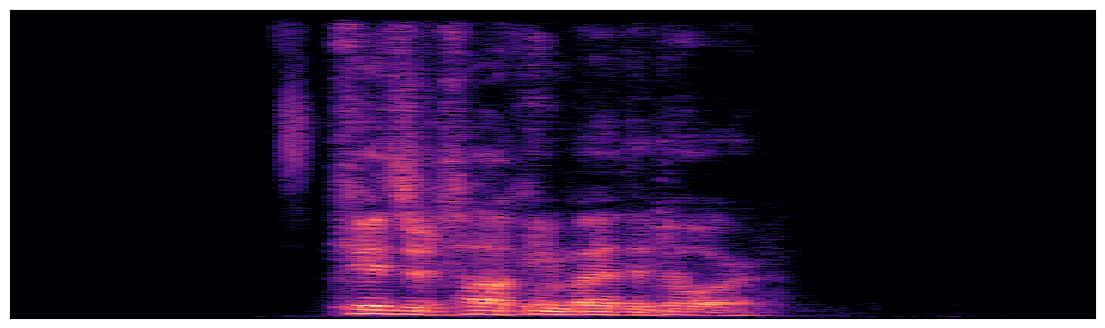

In [29]:
data, sample_rate = librosa.load(file_path)



x2 = stretch(data)
X = librosa.stft(x2)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14,4))
#librosa.display.waveshow(y=x2, sr=sample_rate)
librosa.display.specshow(data=Xdb)

In [30]:
def extract_features(data, sample_rate):
    result = np.array([])

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc))

    # RMS
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    # Spectral Centroid
    centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, centroid))

    # Spectral Rolloff
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate, roll_percent=0.9).T, axis=0)
    result = np.hstack((result, rolloff))

    # # Spectral Flux
    # spectral_flux = np.sqrt(np.sum(np.diff(stft, axis=1)**2, axis=0))
    # spectral_flux_mean = np.mean(spectral_flux)
    # result = np.hstack((result, spectral_flux_mean))

    return result


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data, sample_rate)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [31]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch

emotion_to_num = {
    "neutral": 0,
    "happy": 1,
    "sad": 2,
    "angry": 3,
    "fearful": 4,
    "disgust": 5,
    "surprised": 6
}

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Actor'], random_state=42)

train_val_set, test_set = [], []

# Loop through train_df with tqdm
print("Processing training data...")
for i in tqdm(range(len(train_df)), desc="Train Set"):
    input_features = torch.from_numpy(get_features(os.path.join(file_dir, train_df.iloc[i]['Actor'], train_df.iloc[i]['file_path'])))
    label = torch.tensor(emotion_to_num[train_df.iloc[i]['emotion']], dtype=torch.long)
    train_val_set.append((input_features, label))

# Loop through test_df with tqdm
print("Processing testing data...")
for i in tqdm(range(len(test_df)), desc="Test Set"):
    input_features = torch.from_numpy(get_features(os.path.join(file_dir, test_df.iloc[i]['Actor'], test_df.iloc[i]['file_path'])))
    label = torch.tensor(emotion_to_num[test_df.iloc[i]['emotion']], dtype=torch.long)
    test_set.append((input_features, label))



Processing training data...


/home/ubuntu/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Train Set: 100%|██████████| 998/998 [02:20<00:00,  7.09it/s]


Processing testing data...


Test Set: 100%|██████████| 250/250 [00:35<00:00,  7.02it/s]


In [32]:
train_set, val_set = train_test_split(train_val_set, test_size=0.2, random_state=42)

In [33]:
BATCH_SIZE = 8  # <-- Please change this as necessary
NUM_WORKERS = 4  # <-- Use more workers for more CPU threads

#to train the model
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

#to tune the model
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

#to test on unseen data 
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)

# Creating the model

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [35]:
t, f = next(iter(train_loader))
print(t.size())

torch.Size([8, 3, 156])


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN1DModel(nn.Module):
    def __init__(self):
        super(CNN1DModel, self).__init__()
        
        self.conv1 = nn.Conv1d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AvgPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 156, 128)
        self.fc2 = nn.Linear(128, 7)
        #self.dropout = nn.Dropout(p=0.2)
            
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        #x = self.pool(x)
        x = self.relu(self.conv2(x))
        
        # Calculate the output size after conv layers
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [37]:
def train(train_loader, model, optimizer, criterion, n_epochs=10, patience=3):
    model.train()
    losses = []
    lastepoch_loss = float('inf')  # Initialize to a very high value
    patience_counter = 0  # Count epochs without improvement

    for epoch in tqdm(range(n_epochs)):
        batch_losses = []
        correct, total = 0, 0

        for j, data in enumerate(train_loader, 0):  
            x_batch, y_batch = data
            x_batch = x_batch.to(torch.float32).to(device)  # Convert to float32
            y_batch = y_batch.to(device)

            optimizer.zero_grad()

            y_predictions = model(x_batch)
            loss = criterion(y_predictions, y_batch)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            _, predicted = torch.max(y_predictions, 1)  
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        epoch_loss = np.mean(batch_losses)
        losses.append(epoch_loss)
        epoch_accuracy = 100 * correct / total

        print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.2f}%")

        # Early stopping check
        if abs(lastepoch_loss - epoch_loss) < 0.001:
            patience_counter += 1
        else:
            patience_counter = 0  # Reset if loss improves
        
        if patience_counter >= patience:
            print(f"Stopping early after {epoch+1} epochs due to lack of improvement.")
            break

        lastepoch_loss = epoch_loss  # Update for next epoch

    return losses

In [38]:
import torch
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mymodel = CNN1DModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mymodel.parameters(), lr=1e-3, weight_decay=1e-5)

In [39]:
epochs = 100

losses = train(train_loader, mymodel, optimizer, criterion, epochs)

  1%|          | 1/100 [00:00<01:30,  1.10it/s]

Train Loss: 8.4289 | Train Accuracy: 21.55%


  2%|▏         | 2/100 [00:01<01:01,  1.60it/s]

Train Loss: 2.0007 | Train Accuracy: 28.95%


  3%|▎         | 3/100 [00:01<00:52,  1.87it/s]

Train Loss: 1.7735 | Train Accuracy: 32.33%


  4%|▍         | 4/100 [00:02<00:47,  2.01it/s]

Train Loss: 1.5965 | Train Accuracy: 36.97%


  5%|▌         | 5/100 [00:02<00:45,  2.10it/s]

Train Loss: 1.5238 | Train Accuracy: 39.10%


  6%|▌         | 6/100 [00:03<00:43,  2.16it/s]

Train Loss: 1.4183 | Train Accuracy: 47.24%


  7%|▋         | 7/100 [00:03<00:42,  2.21it/s]

Train Loss: 1.3509 | Train Accuracy: 47.49%


  8%|▊         | 8/100 [00:03<00:41,  2.24it/s]

Train Loss: 1.2989 | Train Accuracy: 49.25%


  9%|▉         | 9/100 [00:04<00:42,  2.16it/s]

Train Loss: 1.2494 | Train Accuracy: 52.63%


 10%|█         | 10/100 [00:04<00:40,  2.20it/s]

Train Loss: 1.1946 | Train Accuracy: 53.38%


 11%|█         | 11/100 [00:05<00:39,  2.23it/s]

Train Loss: 1.1173 | Train Accuracy: 57.27%


 12%|█▏        | 12/100 [00:05<00:38,  2.26it/s]

Train Loss: 1.0917 | Train Accuracy: 57.64%


 13%|█▎        | 13/100 [00:06<00:38,  2.28it/s]

Train Loss: 1.0218 | Train Accuracy: 61.65%


 14%|█▍        | 14/100 [00:06<00:37,  2.29it/s]

Train Loss: 1.0094 | Train Accuracy: 63.53%


 15%|█▌        | 15/100 [00:07<00:36,  2.30it/s]

Train Loss: 0.9468 | Train Accuracy: 65.54%


 16%|█▌        | 16/100 [00:07<00:36,  2.32it/s]

Train Loss: 0.9397 | Train Accuracy: 68.30%


 17%|█▋        | 17/100 [00:07<00:35,  2.32it/s]

Train Loss: 0.8572 | Train Accuracy: 68.42%


 18%|█▊        | 18/100 [00:08<00:35,  2.32it/s]

Train Loss: 0.8117 | Train Accuracy: 71.18%


 19%|█▉        | 19/100 [00:08<00:34,  2.32it/s]

Train Loss: 0.7631 | Train Accuracy: 71.68%


 20%|██        | 20/100 [00:09<00:34,  2.32it/s]

Train Loss: 0.7294 | Train Accuracy: 72.56%


 21%|██        | 21/100 [00:09<00:33,  2.32it/s]

Train Loss: 0.7003 | Train Accuracy: 75.69%


 22%|██▏       | 22/100 [00:10<00:33,  2.33it/s]

Train Loss: 0.6726 | Train Accuracy: 75.69%


 23%|██▎       | 23/100 [00:10<00:33,  2.33it/s]

Train Loss: 0.6460 | Train Accuracy: 80.20%


 24%|██▍       | 24/100 [00:10<00:33,  2.26it/s]

Train Loss: 0.6327 | Train Accuracy: 78.95%


 25%|██▌       | 25/100 [00:11<00:32,  2.29it/s]

Train Loss: 0.5973 | Train Accuracy: 79.20%


 26%|██▌       | 26/100 [00:11<00:32,  2.29it/s]

Train Loss: 0.5373 | Train Accuracy: 82.33%


 27%|██▋       | 27/100 [00:12<00:31,  2.29it/s]

Train Loss: 0.5263 | Train Accuracy: 81.70%


 28%|██▊       | 28/100 [00:12<00:31,  2.28it/s]

Train Loss: 0.4697 | Train Accuracy: 84.59%


 29%|██▉       | 29/100 [00:13<00:31,  2.28it/s]

Train Loss: 0.4456 | Train Accuracy: 84.71%


 30%|███       | 30/100 [00:13<00:30,  2.30it/s]

Train Loss: 0.4141 | Train Accuracy: 87.22%


 31%|███       | 31/100 [00:13<00:30,  2.28it/s]

Train Loss: 0.3739 | Train Accuracy: 86.97%


 32%|███▏      | 32/100 [00:14<00:29,  2.27it/s]

Train Loss: 0.3751 | Train Accuracy: 86.97%


 33%|███▎      | 33/100 [00:14<00:30,  2.23it/s]

Train Loss: 0.3549 | Train Accuracy: 88.72%


 34%|███▍      | 34/100 [00:15<00:30,  2.18it/s]

Train Loss: 0.3104 | Train Accuracy: 90.23%


 35%|███▌      | 35/100 [00:15<00:29,  2.18it/s]

Train Loss: 0.2742 | Train Accuracy: 90.73%


 36%|███▌      | 36/100 [00:16<00:29,  2.16it/s]

Train Loss: 0.3112 | Train Accuracy: 90.23%


 37%|███▋      | 37/100 [00:16<00:29,  2.17it/s]

Train Loss: 0.3120 | Train Accuracy: 88.97%


 38%|███▊      | 38/100 [00:17<00:28,  2.20it/s]

Train Loss: 0.2759 | Train Accuracy: 89.47%


 39%|███▉      | 39/100 [00:17<00:27,  2.21it/s]

Train Loss: 0.2489 | Train Accuracy: 92.11%


 40%|████      | 40/100 [00:18<00:27,  2.22it/s]

Train Loss: 0.2678 | Train Accuracy: 91.23%


 41%|████      | 41/100 [00:18<00:26,  2.23it/s]

Train Loss: 0.1830 | Train Accuracy: 95.24%


 42%|████▏     | 42/100 [00:18<00:25,  2.25it/s]

Train Loss: 0.1681 | Train Accuracy: 95.11%


 43%|████▎     | 43/100 [00:19<00:24,  2.28it/s]

Train Loss: 0.1514 | Train Accuracy: 96.49%


 44%|████▍     | 44/100 [00:19<00:24,  2.28it/s]

Train Loss: 0.2836 | Train Accuracy: 93.48%


 45%|████▌     | 45/100 [00:20<00:24,  2.28it/s]

Train Loss: 0.2836 | Train Accuracy: 90.35%


 46%|████▌     | 46/100 [00:20<00:23,  2.26it/s]

Train Loss: 0.1923 | Train Accuracy: 95.61%


 47%|████▋     | 47/100 [00:21<00:23,  2.27it/s]

Train Loss: 0.1062 | Train Accuracy: 97.49%


 48%|████▊     | 48/100 [00:21<00:22,  2.27it/s]

Train Loss: 0.0906 | Train Accuracy: 98.12%


 49%|████▉     | 49/100 [00:22<00:22,  2.25it/s]

Train Loss: 0.0771 | Train Accuracy: 98.12%


 50%|█████     | 50/100 [00:22<00:22,  2.25it/s]

Train Loss: 0.0869 | Train Accuracy: 97.87%


 51%|█████     | 51/100 [00:22<00:21,  2.26it/s]

Train Loss: 0.0664 | Train Accuracy: 99.37%


 52%|█████▏    | 52/100 [00:23<00:21,  2.28it/s]

Train Loss: 0.0767 | Train Accuracy: 99.25%


 53%|█████▎    | 53/100 [00:23<00:20,  2.25it/s]

Train Loss: 0.0868 | Train Accuracy: 97.74%


 54%|█████▍    | 54/100 [00:24<00:20,  2.23it/s]

Train Loss: 0.0596 | Train Accuracy: 98.87%


 55%|█████▌    | 55/100 [00:24<00:20,  2.24it/s]

Train Loss: 0.0553 | Train Accuracy: 98.62%


 56%|█████▌    | 56/100 [00:25<00:19,  2.24it/s]

Train Loss: 0.0267 | Train Accuracy: 99.87%


 57%|█████▋    | 57/100 [00:25<00:19,  2.24it/s]

Train Loss: 0.0268 | Train Accuracy: 99.75%


 58%|█████▊    | 58/100 [00:26<00:18,  2.22it/s]

Train Loss: 0.0656 | Train Accuracy: 98.75%


 59%|█████▉    | 59/100 [00:26<00:18,  2.21it/s]

Train Loss: 0.0663 | Train Accuracy: 98.12%


 60%|██████    | 60/100 [00:26<00:17,  2.25it/s]

Train Loss: 0.1765 | Train Accuracy: 93.61%


 61%|██████    | 61/100 [00:27<00:17,  2.27it/s]

Train Loss: 0.1356 | Train Accuracy: 95.74%


 62%|██████▏   | 62/100 [00:27<00:16,  2.29it/s]

Train Loss: 0.1049 | Train Accuracy: 96.12%


 63%|██████▎   | 63/100 [00:28<00:16,  2.30it/s]

Train Loss: 0.0911 | Train Accuracy: 96.99%


 64%|██████▍   | 64/100 [00:28<00:15,  2.30it/s]

Train Loss: 0.0686 | Train Accuracy: 97.99%


 65%|██████▌   | 65/100 [00:29<00:15,  2.30it/s]

Train Loss: 0.3112 | Train Accuracy: 91.60%


 66%|██████▌   | 66/100 [00:29<00:14,  2.31it/s]

Train Loss: 0.1113 | Train Accuracy: 96.62%


 67%|██████▋   | 67/100 [00:29<00:14,  2.31it/s]

Train Loss: 0.0762 | Train Accuracy: 97.87%


 68%|██████▊   | 68/100 [00:30<00:13,  2.32it/s]

Train Loss: 0.0273 | Train Accuracy: 99.75%


 69%|██████▉   | 69/100 [00:30<00:13,  2.32it/s]

Train Loss: 0.0123 | Train Accuracy: 100.00%


 70%|███████   | 70/100 [00:31<00:12,  2.32it/s]

Train Loss: 0.0083 | Train Accuracy: 100.00%


 71%|███████   | 71/100 [00:31<00:12,  2.31it/s]

Train Loss: 0.0069 | Train Accuracy: 100.00%


 72%|███████▏  | 72/100 [00:32<00:12,  2.31it/s]

Train Loss: 0.0053 | Train Accuracy: 100.00%


 73%|███████▎  | 73/100 [00:32<00:11,  2.28it/s]

Train Loss: 0.0052 | Train Accuracy: 100.00%


 74%|███████▍  | 74/100 [00:33<00:11,  2.28it/s]

Train Loss: 0.0041 | Train Accuracy: 100.00%


 75%|███████▌  | 75/100 [00:33<00:10,  2.31it/s]

Train Loss: 0.0038 | Train Accuracy: 100.00%


 76%|███████▌  | 76/100 [00:33<00:10,  2.31it/s]

Train Loss: 0.0035 | Train Accuracy: 100.00%


 76%|███████▌  | 76/100 [00:34<00:10,  2.21it/s]

Train Loss: 0.0033 | Train Accuracy: 100.00%
Stopping early after 77 epochs due to lack of improvement.


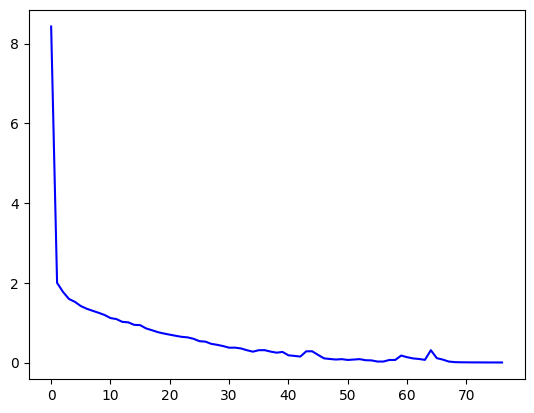

In [40]:
from matplotlib import pyplot as plt 


plt.plot(np.arange(len(losses)), losses, label='Loss Plot', color='blue')

In [41]:
def calculate_accuracy(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    
    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Ensure the input tensor is of type float32
            images = images.float()
            
            outputs = model(images)  # Get model predictions
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            total += labels.size(0)  # Increment the total number of samples
            correct += (predicted == labels).sum().item()  # Count the correct predictions
            
    accuracy = 100 * correct / total
    return accuracy


In [42]:
accuracy = calculate_accuracy(mymodel, val_loader)
print(f'Val Accuracy: {accuracy:.2f}%')


Val Accuracy: 53.00%


In [43]:
accuracy = calculate_accuracy(mymodel, test_loader)
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 60.80%



Classification Report:
               precision    recall  f1-score   support

     neutral     0.6818    0.5769    0.6250        26
       happy     0.6053    0.6053    0.6053        38
         sad     0.6250    0.6944    0.6579        36
       angry     0.5814    0.6579    0.6173        38
     fearful     0.5278    0.5135    0.5205        37
     disgust     0.5789    0.5641    0.5714        39
   surprised     0.6970    0.6389    0.6667        36

    accuracy                         0.6080       250
   macro avg     0.6139    0.6073    0.6092       250
weighted avg     0.6101    0.6080    0.6077       250



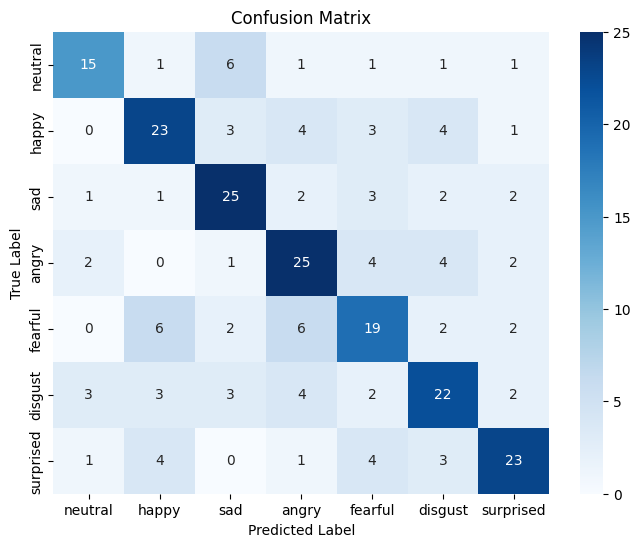

In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define emotion label mappings
emotion_dict = {
    "neutral": 0,
    "happy": 1,
    "sad": 2,
    "angry": 3,
    "fearful": 4,
    "disgust": 5,
    "surprised": 6
}

# Reverse the dictionary to map numbers to emotions
label_names = {v: k for k, v in emotion_dict.items()}

def evaluate_and_plot_results(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations
        for data in test_loader:
            x_batch, y_batch = data
            x_batch = x_batch.to(torch.float32).to(device)
            y_batch = y_batch.to(device)

            y_predictions = model(x_batch)
            _, predicted = torch.max(y_predictions, 1)  # Get predicted class

            all_preds.extend(predicted.cpu().numpy())  # Store predictions
            all_labels.extend(y_batch.cpu().numpy())  # Store actual labels

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Print classification report with emotion labels
    class_report = classification_report(
        all_labels, all_preds, target_names=[label_names[i] for i in range(len(label_names))], digits=4
    )
    print("\nClassification Report:\n", class_report)

    # Plot confusion matrix with emotion labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=[label_names[i] for i in range(len(label_names))],
        yticklabels=[label_names[i] for i in range(len(label_names))]
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return cm, class_report  # Return results for further analysis

# Example usage (assuming test_loader and trained model exist):
cm, report = evaluate_and_plot_results(mymodel, test_loader, device)
